<a href="https://colab.research.google.com/github/minddo/Personalized_emotion_recognition/blob/main/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Preprocessing

In [ ]:
import os
import pandas as pd
import json

## Load data

In [ ]:
path='/content/drive/My Drive/KEMOC/segments'
subject_list=os.listdir(path)

### Dataset description and fill the  missing values

Dataset Description

* Signal data (5초 segement)
1. BVP : 64Hz (총 320개의 data point)
2. Temperature: 4Hz (총 20개의 data point)
3. EDA: 4Hz (총 20개의 data point)
4. ECG: 1Hz (총 5개의 data point)


* Labels (5초마다 tagging)

1. Self arousal/valence
2. Partner arousal/valence
3. External arousal/valence


Imputation

소수의 signal data의 segment에 1~2개정도의 datapoint missing이 발생했다. 주어진 데이터포인트에 timestamp에 대한 정보가 없으므로, 맨 마지막 부분에 그 이전과 동일한 datapoint를 채워넣었다.

In [ ]:
 dataset={}
for subject in subject_list:


    print(subject)

    file_path='/content/drive/My Drive/KEMOC/segments/'+subject+'/'
    file_list=os.listdir(file_path)
    sorted_file_list=sorted(file_list, key=lambda x:int(x.split('-')[1]))

    
    self_arousal=[]
    self_valence=[] 
    partner_arousal=[]
    partner_valence=[]
    external_arousal=[]
    external_valence= [] 
    bvp_320=[]
    bvp_20=[]
    ecg_data=[]
    eda_data=[]
    temp_data=[]


    for file in sorted_file_list:
        
        with open(file_path+file) as f:
            data = json.load(f)

        # assign dataset (fill missing data and remove surplus data)
        # bvp
        bvp=data['bvp']
        len_bvp=len(bvp)
        if len_bvp>320:
            bvp=bvp[:320]
        elif len_bvp<320:
            for i in range(320-len_bvp):
                bvp.append(bvp[-1])
    # ecg
        ecg=data['ecg']
        len_ecg=len(ecg)
        if len_ecg>5:
            ecg=ecg[:5]
        elif len_ecg<5:
            for i in range(5-len_ecg):
                ecg.append(ecg[-1])
        
        
        # eda
        eda=data['eda']
        len_eda=len(eda)
        if len_eda>20:
            eda=eda[:20]
        elif len_eda<20:
            for i in range(20-len_eda):
                eda.append(eda[-1])         



        # temp
        temp=data['temp']
        len_temp=len(temp)
        if len_temp>20:
            temp=temp[:20]

        elif len_temp<20:
            for i in range(20-len_temp):
                temp.append(temp[-1])

        #downsampling 
        df_bvp=pd.DataFrame(bvp,columns=['bvp'])
        df_bvp=df_bvp.rolling(16).mean()
        df_bvp=df_bvp.iloc[list(range(15,320,16)),:].reset_index(drop=True)

        bvp_320.append(bvp)
        bvp_20.append(list(df_bvp['bvp']))
        ecg_data.append(ecg)
        eda_data.append(eda)
        temp_data.append(temp)
        sa,sv,pa,pv,ea,ev=list(map(int,list(file.split('-')[2].split('.')[0])))
        self_arousal.append(sa)
        self_valence.append(sv)
        partner_arousal.append(pa)
        partner_valence.append(pv)
        external_arousal.append(ea)
        external_valence.append(ev)

    ID=file.split('-')[0]
    dataset[ID]={"data":{"bvp_320":bvp_320, "bvp_20":bvp_20, "ecg":ecg_data, "eda": eda_data, "temp": temp_data},
                "labels": {"self_arousal":self_arousal, "self_valence":self_valence, "partner_arousal": partner_arousal, 'partner_valence': partner_valence, 'external_arousal': external_arousal, 'external_valence':external_valence}}


### Over sampling

Early fusion을 위해 ECG data를 1Hz -> 4Hz로 over-sampling

In [ ]:
from scipy.interpolate import interp1d
import numpy as np

t=np.linspace(1,5,num=5, endpoint=True)
t_new=np.linspace(1,5,num=20, endpoint=True)


for ID in dataset.keys():
    ecg_20=[]
    for data in dataset[ID]['data']['ecg']:
        f=interp1d(t,data)
        new_x=f(t_new)
        ecg_20.append(list(new_x))
        dataset[ID]['data']['ecg_20']=ecg_20  

### Normalization

min-max scaler를 이용

In [ ]:
def min_max_norm_bvp320(x):
    return (x-min_bvp320)/(max_bvp320-min_bvp320)

def min_max_norm_bvp20(x):

    return (x-min_bvp20)/(max_bvp20-min_bvp20)

def min_max_norm_ecg(x):

    return (x-min_ecg)/(max_ecg-min_ecg)

def min_max_norm_eda(x):

    return (x-min_eda)/(max_eda-min_eda)


def min_max_norm_temp(x):

    return (x-min_temp)/(max_temp-min_temp)




def low_high(x):
    if x>2:
        return 1
    else:
        return 0

from keras.utils import to_categorical

In [ ]:
import numpy as np
dataset2={}

for ID in dataset.keys():
    df_sample=dataset[ID]

    min_bvp320=min([min(x) for x in df_sample['data']['bvp_320']])
    max_bvp320=max([max(x) for x in df_sample['data']['bvp_320']])
    min_bvp20=min([min(x) for x in df_sample['data']['bvp_20']])
    max_bvp20=max([max(x) for x in df_sample['data']['bvp_20']])
    min_ecg=min([min(x) for x in df_sample['data']['ecg_20']])
    max_ecg=max([max(x) for x in df_sample['data']['ecg_20']])
    min_eda=min([min(x) for x in df_sample['data']['eda']])
    max_eda=max([max(x) for x in df_sample['data']['eda']])
    min_temp=min([min(x) for x in df_sample['data']['temp']])
    max_temp=max([max(x) for x in df_sample['data']['temp']])



    bvp_320_scaled=np.array(pd.DataFrame(df_sample['data']['bvp_320']).applymap(min_max_norm_bvp320))
    bvp_20_scaled=np.array(pd.DataFrame(df_sample['data']['bvp_20']).applymap(min_max_norm_bvp20))
    ecg_scaled=np.array(pd.DataFrame(df_sample['data']['ecg']).applymap(min_max_norm_ecg))
    ecg_20_scaled=np.array(pd.DataFrame(df_sample['data']['ecg_20']).applymap(min_max_norm_ecg))
    temp_scaled=np.array(pd.DataFrame(df_sample['data']['temp']).applymap(min_max_norm_temp))
    eda_scaled=np.array(pd.DataFrame(df_sample['data']['eda']).applymap(min_max_norm_eda))


    self_arousal=pd.DataFrame(df_sample['labels']['self_arousal']).applymap(low_high)
    self_valence=pd.DataFrame(df_sample['labels']['self_valence']).applymap(low_high)
    partner_arousal=pd.DataFrame(df_sample['labels']['partner_arousal']).applymap(low_high)
    partner_valence=pd.DataFrame(df_sample['labels']['partner_valence']).applymap(low_high)
    external_arousal=pd.DataFrame(df_sample['labels']['external_arousal']).applymap(low_high)
    external_valence=pd.DataFrame(df_sample['labels']['external_valence']).applymap(low_high)

    self_arousal=to_categorical(self_arousal)
    self_valence=to_categorical(self_valence)
    partner_arousal=to_categorical(partner_arousal)
    partner_valence=to_categorical(partner_valence)
    external_arousal=to_categorical(external_arousal)
    external_arousal=to_categorical(external_arousal)

    dataset2[ID]={"data":{"bvp":bvp_20_scaled, "ecg":ecg_20_scaled, "eda": eda_scaled, "temp": temp_scaled},
            "labels": {"self_arousal":self_arousal, "self_valence":self_valence, "partner_arousal": partner_arousal, 'partner_valence': partner_valence, 'external_arousal': external_arousal, 'external_valence':external_valence}}


#  Visualization

## Before preprocessing

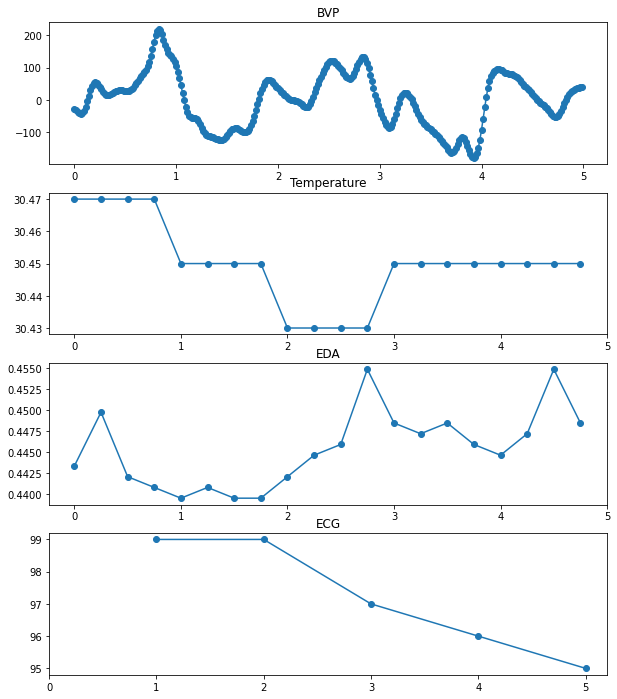

In [ ]:
data=dataset['p11']['data']
import numpy as np
import matplotlib.pyplot as plt
t1=np.arange(1.,6.,1/1)
t2=np.arange(0.,5.,1/4)
t3=np.arange(0.,5.,1/64)


plt.figure(figsize=(10,12))

plt.subplot(4, 1, 1)
plt.plot(t3, data['bvp_320'][0], 'o-')
plt.xticks(np.arange(0, 6, step=1))

plt.title('BVP')


plt.subplot(4, 1, 2)
plt.plot(t2, data['temp'][0], 'o-')
plt.xticks(np.arange(0, 6, step=1))
plt.title('Temperature')



plt.subplot(4, 1, 3)
plt.plot(t2, data['eda'][0], 'o-')
plt.xticks(np.arange(0, 6, step=1))
plt.title('EDA')



plt.subplot(4, 1, 4)
plt.plot(t1, data['ecg'][0], 'o-')
plt.xticks(np.arange(0, 6, step=1))
plt.title('ECG')

plt.savefig('fig1.png', dpi=300)
plt.show()

##After preprocessing

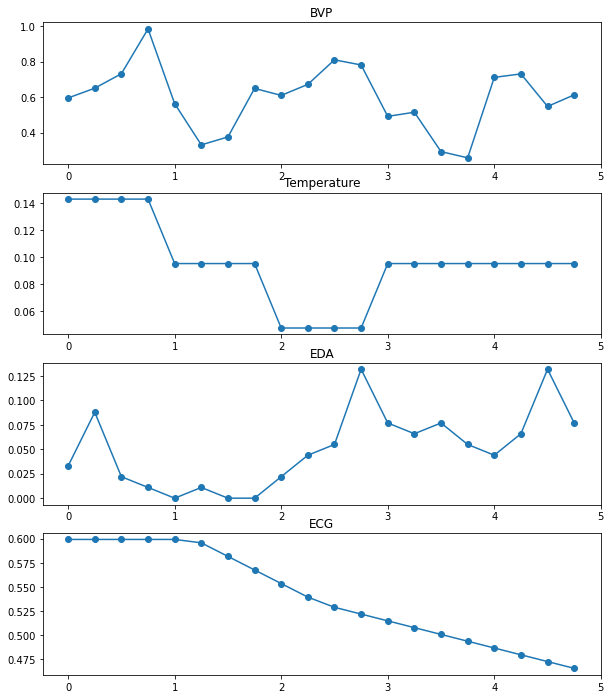

In [ ]:
data=dataset2['p11']['data']
import numpy as np
import matplotlib.pyplot as plt
t1=np.arange(1.,6.,1/1)
t2=np.arange(0.,5.,1/4)
t3=np.arange(0.,5.,1/64)


plt.figure(figsize=(10,12))

plt.subplot(4, 1, 1)
plt.plot(t2, data['bvp'][0], 'o-')
plt.xticks(np.arange(0, 6, step=1))

plt.title('BVP')


plt.subplot(4, 1, 2)
plt.plot(t2, data['temp'][0], 'o-')
plt.xticks(np.arange(0, 6, step=1))
plt.title('Temperature')



plt.subplot(4, 1, 3)
plt.plot(t2, data['eda'][0], 'o-')
plt.xticks(np.arange(0, 6, step=1))
plt.title('EDA')



plt.subplot(4, 1, 4)
plt.plot(t2, data['ecg'][0], 'o-')
plt.xticks(np.arange(0, 6, step=1))
plt.title('ECG')

plt.savefig('fig2.png', dpi=300)

plt.show()

# Control input length 

segment의 길이를 조절

e.g., 5초, 10초

In [ ]:
dataset3={}
length=10  #3초
number_of_segment=length//5
for ID in dataset2.keys():
    bvp=[]
    temp=[]
    ecg=[]
    eda=[]

    for i in range(len(dataset2[ID]['data']['bvp'])-number_of_segment):
        
        temp_bvp=np.array([])
        temp_temp=np.array([])
        temp_ecg=np.array([])
        temp_eda=np.array([])
        for j in range(number_of_segment):
            temp_bvp=np.append(temp_bvp,dataset2[ID]['data']['bvp'][i+j])
            temp_temp=np.append(temp_temp,dataset2[ID]['data']['temp'][i+j])
            temp_ecg=np.append(temp_ecg,dataset2[ID]['data']['ecg'][i+j])
            temp_eda=np.append(temp_eda,dataset2[ID]['data']['eda'][i+j])
            
        bvp.append(temp_bvp)
        temp.append(temp_temp)
        ecg.append(temp_ecg)
        eda.append(temp_eda)

    bvp=np.array(bvp)
    temp=np.array(temp)
    ecg=np.array(ecg)
    eda=np.array(eda)

    arousal=dataset2[ID]['labels']['self_arousal'][:-number_of_segment]
    valence=dataset2[ID]['labels']['self_valence'][:-number_of_segment]
    dataset3[ID]={"data":{"bvp":bvp, "ecg":ecg, "eda":eda, "temp":temp}, "labels": {"self_arousal": arousal,"self_valence": valence}}

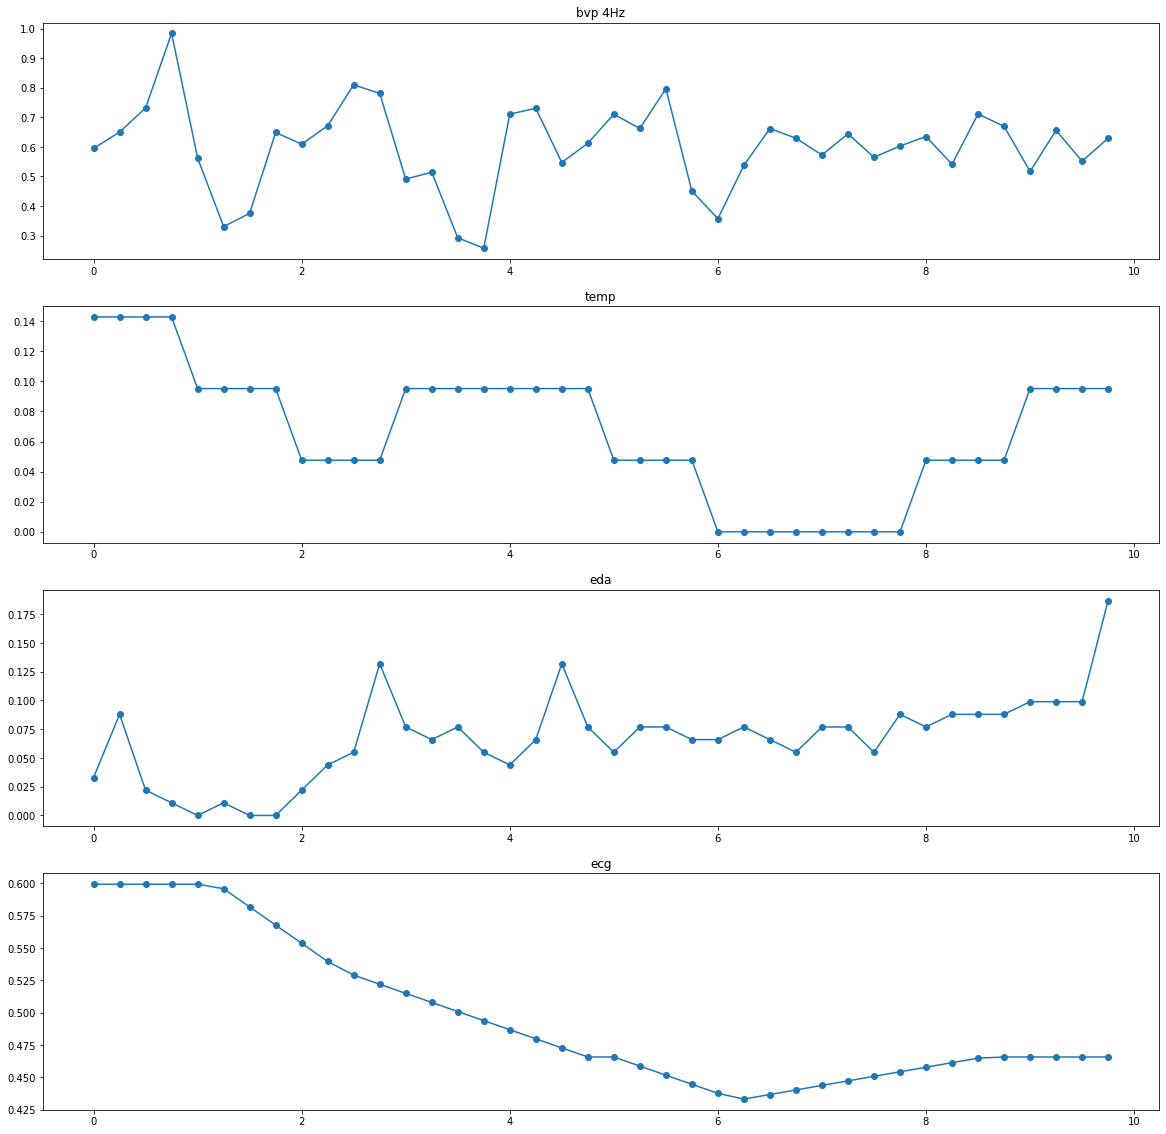

In [ ]:
data=dataset3['p11']['data']
import numpy as np
import matplotlib.pyplot as plt

t2=np.arange(0.,10.,1/4)
plt.figure(figsize=(20,20))

plt.subplot(4, 1, 1)
plt.plot(t2, data['bvp'][0], 'o-')
plt.title('bvp 4Hz')


plt.subplot(4, 1, 2)
plt.plot(t2, data['temp'][0], 'o-')
plt.title('temp')



plt.subplot(4, 1, 3)
plt.plot(t2, data['eda'][0], 'o-')
plt.title('eda')



plt.subplot(4, 1, 4)
plt.plot(t2, data['ecg'][0], 'o-')
plt.title('ecg')



plt.show()